<a href="https://colab.research.google.com/github/Manuelstv/Dados-Astronomicos/blob/main/VIT_version_1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.4 MB/s 


In [ ]:
pip install tensorflow-determinism

  Created wheel for tensorflow-determinism: filename=tensorflow_determinism-0.3.0-py3-none-any.whl size=9158 sha256=994f1b4c0c9000709731718ed470bd11850f52c24b063497525af680336e626e
  Stored in directory: /root/.cache/pip/wheels/d2/be/33/2b27e81e5d40b4bfb7c103ac6c6c5e81fdbcf40d2af5078529
Successfully built tensorflow-determinism


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
import tensorflow_addons as tfa
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle

In [ ]:
# scikit-learn for Machine Learning
# Preprocessing
from sklearn.manifold import TSNE # Dimensionality reduction technique
from sklearn.model_selection import GridSearchCV #Cross-Validation
from sklearn.utils import resample #Resampling
# Metrics
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [ ]:
SEED = 123456
import os
import random as rn
import numpy as np
import tensorflow as tf

os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_DETERMINISTIC_OPS'] = '1'
np.random.seed(SEED)
tf.random.set_seed(SEED)
rn.seed(SEED)

from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [ ]:
# Mount drive to upload the datasets
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive

/content/drive/MyDrive


In [ ]:
#X_pos = np.float64(np.load("/content/drive/My Drive/datasets/original/LSBGs.npy"))
#X_neg = np.float64(np.load("/content/drive/My Drive/datasets/original/negatives2.npy"))

FileNotFoundError: ignored

# Load data

In [ ]:
#x_train = np.zeros((30000,64,64,3))
#x_train[0:15000] = X_pos[0:15000]
#x_train[15000:30000] = X_neg[0:15000]
#y_train = np.zeros(30000)
#y_train[0:15000] = np.ones(15000)
#x_train, y_train = shuffle(x_train, y_train)
#np.save('x_train', x_train)
#np.save('y_train', y_train)
y_train = np.float64(np.load("/content/drive/My Drive/datasets/original/y_train.npy"))
x_train = np.float64(np.load("/content/drive/My Drive/datasets/original/x_train.npy"))

#x_val = np.zeros((5000,64,64,3))
#x_val[0:2500] = X_pos[15000:17500]
#x_val[2500:5000] = X_neg[15000:17500]
#np.save('x_val', x_val)
#y_val = np.zeros(5000)
#y_val[0:2500] = np.ones(2500)
#x_val, y_val = shuffle(x_val, y_val)
#np.save('y_val', y_val)
#np.save('x_val', x_val)
y_val = np.float64(np.load("/content/drive/My Drive/datasets/original/y_val.npy"))
x_val = np.float64(np.load("/content/drive/My Drive/datasets/original/x_val.npy"))

#x_test = np.zeros((4995,64,64,3))
#x_test[0:2495] = X_pos[17500:19995]
#x_test[2495:4995] = X_neg[17500:20000]
#y_test = np.zeros(4995)
#y_test[0:2495] = np.ones(2495)
#x_test, y_test = shuffle(x_test, y_test)
#np.save('y_test', y_test)
#np.save('x_test', x_test)
y_test = np.float64(np.load("/content/drive/My Drive/datasets/original/y_test.npy"))
x_test = np.float64(np.load("/content/drive/My Drive/datasets/original/x_test.npy"))

In [ ]:
x_train = x_train/255
x_val = x_val/255
x_test = x_test/255

## Prepare the data

In [ ]:
num_classes = 2
input_shape = (64, 64, 3)

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")
print(f"x_val shape: {x_val.shape} - y_test shape: {y_val.shape}")

x_train shape: (30000, 64, 64, 3) - y_train shape: (30000,)
x_test shape: (4995, 64, 64, 3) - y_test shape: (4995,)
x_val shape: (5000, 64, 64, 3) - y_test shape: (5000,)


## Configure the hyperparameters

In [ ]:
learning_rate = 0.002
weight_decay = 0.0001
batch_size = 256
num_epochs = 25
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 10
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

## Use data augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomFlip("vertical"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
           height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

## Implement multilayer perceptron (MLP)

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## Implement patch creation as a layer

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

## Implement the patch encoding layer

The `PatchEncoder` layer will linearly transform a patch by projecting it into a
vector of size `projection_dim`. In addition, it adds a learnable position
embedding to the projected vector.

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

## Build the ViT model

The ViT model consists of multiple Transformer blocks,
which use the `layers.MultiHeadAttention` layer as a self-attention mechanism
applied to the sequence of patches. The Transformer blocks produce a
`[batch_size, num_patches, projection_dim]` tensor, which is processed via an
classifier head with softmax to produce the final class probabilities output.

Unlike the technique described in the [paper](https://arxiv.org/abs/2010.11929),
which prepends a learnable embedding to the sequence of encoded patches to serve
as the image representation, all the outputs of the final Transformer block are
reshaped with `layers.Flatten()` and used as the image
representation input to the classifier head.
Note that the `layers.GlobalAveragePooling1D` layer
could also be used instead to aggregate the outputs of the Transformer block,
especially when the number of patches and the projection dimensions are large.

In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)

    return model

## Compile, train, and evaluate the mode

In [ ]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/25
106/106 [==============================] - 134s 1s/step - loss: 2.2881 - accuracy: 0.7727 - top-5-accuracy: 1.0000 - val_loss: 0.3506 - val_accuracy: 0.8650 - val_top-5-accuracy: 1.0000
Epoch 2/25
106/106 [==============================] - 115s 1s/step - loss: 0.3227 - accuracy: 0.8760 - top-5-accuracy: 1.0000 - val_loss: 0.2719 - val_accuracy: 0.8913 - val_top-5-accuracy: 1.0000
Epoch 3/25
106/106 [==============================] - 115s 1s/step - loss: 0.2919 - accuracy: 0.8887 - top-5-accuracy: 1.0000 - val_loss: 0.2703 - val_accuracy: 0.9023 - val_top-5-accuracy: 1.0000
Epoch 4/25
106/106 [==============================] - 115s 1s/step - loss: 0.2749 - accuracy: 0.8993 - top-5-accuracy: 1.0000 - val_loss: 0.2524 - val_accuracy: 0.9083 - val_top-5-accuracy: 1.0000
Epoch 5/25
106/106 [==============================] - 114s 1s/step - loss: 0.2723 - accuracy: 0.8980 - top-5-accuracy: 1.0000 - val_loss: 0.2777 - val_accuracy: 0.9027 - val_top-5-accuracy: 1.0000
Epoch 6/25
106/

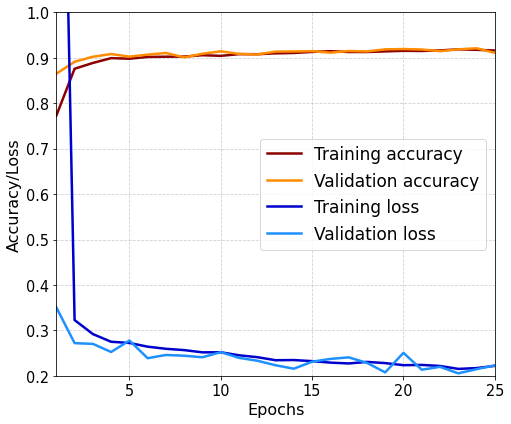

In [ ]:
Epochs = np.arange(1,num_epochs+1,1)
history_dict = history.history

train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_err = 1.0 - np.asarray(train_acc)
val_err = 1.0 - np.asarray(val_acc)

# =====================================================================
plt.figure(figsize=(7.2, 6.0))

# Plot Accuracy
plt.plot(Epochs, train_acc, c = 'darkred',linewidth=2.5,label='Training accuracy')
plt.plot(Epochs, val_acc , c = 'darkorange',linewidth=2.5,label='Validation accuracy')
# Plot Loss
plt.plot(Epochs, train_loss, c = 'mediumblue',linewidth=2.5,label='Training loss')
plt.plot(Epochs, val_loss , c = 'dodgerblue',linewidth=2.5,label='Validation loss')

# =====================================================================
plt.grid(ls='--',alpha=0.6)
plt.xlabel('Epochs', fontsize=16);plt.ylabel('Accuracy/Loss',fontsize=16)
plt.xlim(1,num_epochs)
plt.ylim(0.2,1)
plt.legend(frameon=True, loc='center right', fontsize=17)
plt.tick_params(axis='both', labelsize=14.5)

plt.tight_layout()
plt.show()

In [ ]:
'''x = vit_classifier.predict(x_test)

def softmax(vec):
  exponential = np.exp(vec)
  probabilities = exponential / np.sum(exponential)
  return probabilities

for i in range(0,x.shape[0]):
  x[i,:] = softmax(x[i,:])
  
def gambiarra(vec):
  a = np.zeros(vec.shape[0])
  for i in range(0,vec.shape[0]):
    if(vec[i,1]>0.5):
      a[i] = 1
    else:
      a[i]=0
  return a

y_pred_DL_2 = gambiarra(x)  
  
'''

'x = vit_classifier.predict(x_test)\n\ndef softmax(vec):\n  exponential = np.exp(vec)\n  probabilities = exponential / np.sum(exponential)\n  return probabilities\n\nfor i in range(0,x.shape[0]):\n  x[i,:] = softmax(x[i,:])\n  \ndef gambiarra(vec):\n  a = np.zeros(vec.shape[0])\n  for i in range(0,vec.shape[0]):\n    if(vec[i,1]>0.5):\n      a[i] = 1\n    else:\n      a[i]=0\n  return a\n\ny_pred_DL_2 = gambiarra(x)  \n  \n'

In [ ]:
# Predict on test data 
probs = tf.nn.softmax(vit_classifier.predict(x_test))
y_pred_DL= np.argmax(probs,axis=1)
#y_pred_DL = (tf.nn.softmax(vit_classifier.predict(x_test))(x_test)[:,1]) > 0.5)
# Print classification metrics 
print("Accuracy score for DL:",accuracy_score(y_test,y_pred_DL))
print("Precision score for DL:",precision_score(y_test,y_pred_DL))
print("Recall score for DL:",recall_score(y_test,y_pred_DL))

Accuracy score for DL: 0.9291291291291291
Precision score for DL: 0.9053388867853086
Recall score for DL: 0.958316633266533


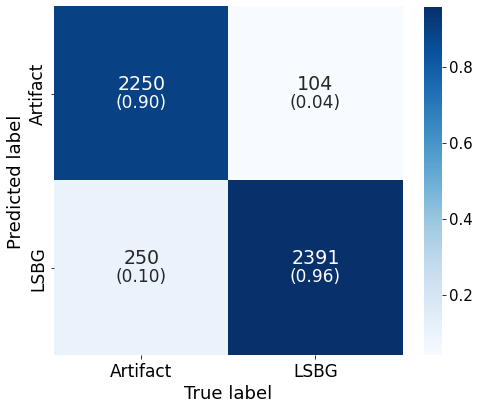

In [ ]:
# Get the confusion matrix for the Deep Learning
con_mat_DL = confusion_matrix(y_test, y_pred_DL)

# Get annotations and normalized confusion matrix
a = con_mat_DL[0]/np.sum(con_mat_DL[0])
b = con_mat_DL[1]/np.sum(con_mat_DL[1])

con_mat_normalized = np.zeros([2,2])
con_mat_normalized[0] = a
con_mat_normalized[1] = b

# Annotations
an_1 = "("+"{:.2f}".format(a[0])+")"
an_2 = "("+"{:.2f}".format(a[1])+")"
an_3 = "("+"{:.2f}".format(b[0])+")"
an_4 = "("+"{:.2f}".format(b[1])+")"

annots = np.zeros([2,2],dtype='U6')

annots[0,0] = an_1;annots[0,1] = an_2
annots[1,0] = an_3;annots[1,1] = an_4

class_names = ['Artifact','LSBG']
# ==============================================

plt.figure(figsize = (7,6.0))
g =sns.heatmap(con_mat_DL.T, square = True, annot=True,annot_kws={'va':'bottom',"size": 19},fmt='.0f', cmap='Blues', cbar=False, 
           xticklabels= class_names,
           yticklabels= class_names)
sns.heatmap(con_mat_normalized.T, square=True, annot=annots.T, annot_kws={'va':'top',"size": 17},cmap='Blues',fmt='', cbar=True,
            cbar_kws={'shrink':0.94})
g.set_xticklabels(class_names, fontsize = 17)
g.set_yticklabels(class_names, fontsize = 17)

# Ticks for colorbar
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=15)
# =========================================
plt.xlabel('True label',fontsize=18)
plt.ylabel('Predicted label',fontsize=18)

plt.tight_layout()
plt.show()

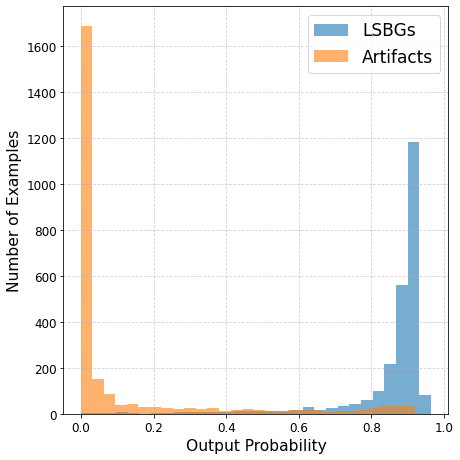

In [ ]:
# First let's predict probabilities on the test set
scores_DL = probs[:,1]

plt.figure(figsize = (6.5,6.5))

plt.hist(scores_DL[y_test==1.0],bins=30,alpha=0.6,density=False,label='LSBGs')
plt.hist(scores_DL[y_test==0.0],bins=30,alpha=0.6,density=False,label='Artifacts')
# ==============================================================================
plt.grid(ls='--',alpha=0.6)
plt.tick_params(axis='both', labelsize=12)
plt.legend(frameon=True, loc='upper right', fontsize=17)

plt.xlabel("Output Probability", fontsize=15.5)
plt.ylabel("Number of Examples", fontsize=15.5)

plt.tight_layout()
plt.show()

In [ ]:
X_misc_Art = x_test[(scores_DL>0.8)&(y_test==0.0)] #Artefacts classified as LSBGs
X_misc_LSBG = x_test[(scores_DL<0.2)&(y_test==1.0)] #LSBGs classified as Artefacts
# ==============================================================================
# Get probabilities/scores 
P_misc_Art = scores_DL[(scores_DL>0.8)&(y_test==0.0)] #Artefacts classified as LSBGs
P_misc_LSBG = scores_DL[(scores_DL<0.2)&(y_test==1.0)] #LSBGs classified as Artefacts
# ==============================================================================
# Print numbers of each one
print(len(P_misc_Art),len(P_misc_LSBG))

125 22


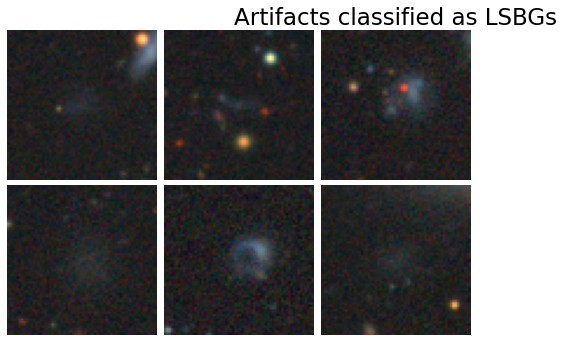

In [ ]:
# Plot them
n_rows = 2
n_cols = 3

plt.figure(figsize=(4*n_cols*0.7, 4*n_rows*0.7))

for i in range(n_rows*n_cols):
    if (i==3):
        plt.title("Artifacts classified as LSBGs",fontsize=23)
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(X_misc_LSBG[i])
    plt.axis('off')

plt.subplots_adjust(wspace=0.01, hspace=0.03)
#plt.tight_layout()
plt.show()

In [ ]:
X_corr_Art = x_test[(scores_DL>0.4)&(scores_DL<0.5)&(y_test==0.0)] #Artifacts classified as LSBGs
X_corr_LSBG = x_test[(scores_DL>0.5)&(scores_DL<0.6)&(y_test==1.0)] #LSBGs classified as LSBGs
# ==============================================================================
# Get probabilities/scores 
P_corr_Art = scores_DL[(scores_DL>0.4)&(scores_DL<0.5)&(y_test==0.0)] #Artifacts classified as Artefacts
P_corr_LSBG = scores_DL[(scores_DL>0.5)&(scores_DL<0.6)&(y_test==1.0)] #LSBGs classified as LSBGs
# ==============================================================================
# Print numbers of each one
print(len(P_corr_Art),len(P_corr_LSBG))

54 37


In [ ]:
def bootstrap(y_pred, y_pred_proba,y_test_loc):
  n_bootstraps = 1000 

  # Classification metrics that we want to estimate
  # ===============================================================
  boot_accuracy = np.zeros(n_bootstraps)
  boot_precision = np.zeros(n_bootstraps) #Also known as purit
  boot_recall = np.zeros(n_bootstraps) # Also known as completeness
  boot_tprs = np.zeros((n_bootstraps,200)) # True positive rates
  boot_auc = np.zeros(n_bootstraps) # AUC
  fprs = np.linspace(0,1,200) # False positive rates
  # ===============================================================
  indices = np.arange(len(y_test_loc))

  for i in range(n_bootstraps):
    # Get local indices by resampling
    ind_loc = resample(indices, n_samples=len(indices), replace=True)

    # ================================================================================
    # Now get "local" test samples, meaning those resulting from resampling

    y_pred_loc = y_pred[ind_loc]  #Prediction 
    y_pred_prob_loc = y_pred_proba[ind_loc] #Probability prediction
    y_true_loc = y_test_loc[ind_loc] #True labels of the test set

    # ================================================================================
    # Now estimate the evaluation metrics for the current resampling

    boot_accuracy[i] = accuracy_score(y_true_loc, y_pred_loc) #Accuracy
    boot_precision[i] = precision_score(y_true_loc, y_pred_loc) #Precision
    boot_recall[i] = recall_score(y_true_loc, y_pred_loc) #Recall
    boot_auc[i] = roc_auc_score(y_true_loc, y_pred_prob_loc[:,0]) #AUC score 

    # And now for the true positive rate, in order to get the errors on the ROC curve

    fpr_loc, tpr_loc, thresholds_loc = roc_curve(y_true_loc, y_pred_prob_loc[:,1], pos_label=1.0)
    fpr_unique, ind_unique = np.unique(fpr_loc,return_index=True)
    tpr_unique = tpr_loc[ind_unique]

    # interpolate the false positive - true positives
    interp = interpolate.interp1d(fpr_unique, tpr_unique, kind='linear')
    boot_tprs[i,:] = interp(fprs)

  # =================================================================================
  # return them 
  return boot_accuracy,boot_precision,boot_recall,boot_auc,boot_tprs

In [ ]:
# For Deep Learning - Deep Shadows 
scores_DL = vit_classifier.predict(x_test)

In [ ]:
from scipy import interpolate
acc_boot_DL, prec_boot_DL, rec_boot_DL, auc_boot_DL, tprs_boot_DL = bootstrap(y_pred_DL, scores_DL, y_test)

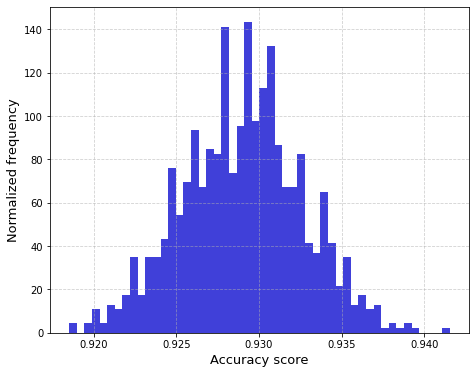

In [ ]:
# For Accuracy - note, the plot is just for our inspection, we are not going to show it in the paper 
plt.figure(figsize=(7.5, 6.0))

plt.hist(acc_boot_DL, bins=50,color='mediumblue',alpha=0.75, density=True)
plt.grid(ls='--',alpha=0.6)

plt.xlabel('Accuracy score',fontsize=13);plt.ylabel('Normalized frequency',fontsize=13)
plt.show()

In [ ]:
# Precision
# sort
prec_boot_DL.sort()
# Computing the lower and upper bound of the 95% confidence interval
conf_lower_prec_DL = prec_boot_DL[int(0.025 * len(prec_boot_DL))]
conf_upper_prec_DL = prec_boot_DL[int(0.975 * len(prec_boot_DL))]
# Print confidence interval
print("Precision confidence intervals, DeepShadows:",conf_lower_prec_DL,conf_upper_prec_DL)
# ==============================================================================
# Recall

# sort
rec_boot_DL.sort()
# Computing the lower and upper bound of the 95% confidence interval
conf_lower_rec_DL = rec_boot_DL[int(0.025 * len(rec_boot_DL))]
conf_upper_rec_DL = rec_boot_DL[int(0.975 * len(rec_boot_DL))]
# Print confidence interval
print("Recall confidence intervals, DeepShadows:",conf_lower_rec_DL,conf_upper_rec_DL)
# ==============================================================================
# AUC score

# sort
auc_boot_DL.sort()
# Computing the lower and upper bound of the 95% confidence interval
conf_lower_auc_DL = auc_boot_DL[int(0.025 * len(auc_boot_DL))]
conf_upper_auc_DL = auc_boot_DL[int(0.975 * len(auc_boot_DL))]
# Print confidence interval
print("AUC confidence intervals, DeepShadows:",conf_lower_auc_DL,conf_upper_auc_DL)

# sort
acc_boot_DL.sort()
# Computing the lower and upper bound of the 95% confidence interval
conf_lower_acc_DL = acc_boot_DL[int(0.025 * len(acc_boot_DL))]
conf_upper_acc_DL = acc_boot_DL[int(0.975 * len(acc_boot_DL))]
# Print confidence interval
print("Acuracy confidence intervals, DeepShadows:",conf_lower_acc_DL,conf_upper_acc_DL)

Precision confidence intervals, DeepShadows: 0.893922234805587 0.9164810690423163
Recall confidence intervals, DeepShadows: 0.9501430322844299 0.9662243667068757
AUC confidence intervals, DeepShadows: 0.0435073376714165 0.05748478409045347
Acuracy confidence intervals, DeepShadows: 0.9221221221221221 0.9363363363363363


In [ ]:
# For Deep Learning - Deep Shadows 
scores_DL = vit_classifier.predict(x_test)

In [ ]:
# For Deep Learning - Deep Shadows 
fpr_DL, tpr_DL, thresholds_DL = roc_curve(y_test, scores_DL[:,1], pos_label=1.0)

In [ ]:
fprs = np.linspace(0,1,200) # False positive rates

# For Deep Learning - Deep shadows

# Create empty arrays - to store the intervals
lower_tprs_DL = np.zeros(200)
upper_tprs_DL = np.zeros(200)

for i in range(200):
  tprs_boot_DL_loc = tprs_boot_DL[:,i]

  #sort it
  tprs_boot_DL_loc.sort()
  # Compute the lower and upper bound of the 95% confidence interval
  lower_tprs_DL[i] = tprs_boot_DL_loc[int(0.025 * len(tprs_boot_DL_loc))]
  upper_tprs_DL[i] = tprs_boot_DL_loc[int(0.975 * len(tprs_boot_DL_loc))]  

In [ ]:
# AUC DL
AUC_DL = roc_auc_score(y_test, scores_DL[:,1])
# ========================================================
print("AUC score for DL:",AUC_DL)

AUC score for DL: 0.9758254108216433


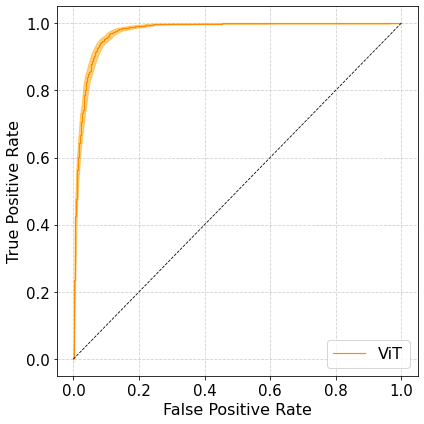

In [ ]:
x = np.linspace(0,1,100)
plt.figure(figsize = (6.0,6.0))

# Deep Learning and confidence interval
plt.plot(fpr_DL,tpr_DL,c='darkorange',linewidth=1.2, label='ViT')
plt.fill_between(fprs,lower_tprs_DL, upper_tprs_DL,color='orange',rasterized=True,alpha=0.5)

plt.plot(x,x, c='k',ls='--',linewidth=0.8)
plt.grid(ls='--', alpha=0.6)

#plt.title('ROC curve')
plt.xlabel('False Positive Rate',fontsize=16);plt.ylabel('True Positive Rate',fontsize=16)
plt.legend(frameon=True, loc='lower right', fontsize=16)
plt.tick_params(axis='both', labelsize=15)

plt.tight_layout()
plt.show()

In [ ]:
print("{:.4f} & {:.4f} & {:.4f} & {:.4f}".format(accuracy_score(y_test,y_pred_DL),AUC_DL,recall_score(y_test,y_pred_DL),precision_score(y_test,y_pred_DL)))

0.9291 & 0.9758 & 0.9583 & 0.9053
